<a href="https://colab.research.google.com/github/csabi0312/crypto-svm/blob/gru/crypto14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from numpy import trapz
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from numpy import trapz
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import keras.losses
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
import umap
import datetime

import datetime
from sklearn.metrics import mean_squared_error as mse

In [17]:
pip install rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
from rich.progress import track

# DATA

In [ ]:
raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv",parse_dates = ["Date"], index_col = "Date").dropna()
raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
raw["Volume"]=raw["Volume USDT"]
raw.drop(["Open","Unix","Symbol","Volume USDT","Volume BTC","tradecount"],axis=1,inplace=True)
raw

,High,Low,Close,returns,Volume
Date,,,,,
2023-02-12,22090.00,21630.00,21783.54,NaN,4.469822e+09
2023-02-11,21906.32,21599.78,21862.55,0.003620,3.842001e+09
2023-02-10,21938.16,21451.00,21625.19,-0.010916,7.369456e+09
2023-02-09,23011.39,21688.00,21796.35,0.007884,9.052973e+09
2023-02-08,23452.00,22665.85,22963.00,0.052142,6.457586e+09
...,...,...,...,...,...
2017-08-21,4119.62,3911.79,4016.00,-0.005958,2.797232e+06
2017-08-20,4211.08,4032.62,4086.29,0.017351,1.930364e+06
2017-08-19,4184.69,3850.00,4139.98,0.013053,1.549484e+06


In [ ]:
raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv",parse_dates = ["Date"], index_col = "Date").dropna()
raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
raw["Volume"]=raw["Volume USDT"]
raw.drop(["Open","Unix","Symbol","Volume USDT","Volume BTC","tradecount"],axis=1,inplace=True)
cols = []
for lag in range(1, 31):
    col_h = "h_lag{}".format(lag)
    col_l = "l_lag{}".format(lag)
    col_r = "c_lag{}".format(lag)
    col_v = "v_lag{}".format(lag)
    raw[col_h] = raw.High.shift(lag)
    cols.append(col_h)
    raw[col_l] = raw.Low.shift(lag)
    cols.append(col_l)
    raw[col_r] = raw.Close.shift(lag)
    cols.append(col_r)
    raw[col_v] = raw.Volume.shift(lag)
    cols.append(col_v)
    raw.dropna(inplace = True)
raw.drop(["High","Low","Volume","Close"],axis=1,inplace=True)

raw["returns2"]=(raw["returns"]>=0).astype(int)

to=int(len(raw)*0.8)
X_train=raw.drop(["returns2","returns"],axis=1).iloc[:to].to_numpy()
y_train=raw["returns2"].iloc[:to].to_numpy().astype(int)
X_test=raw.drop(["returns2","returns"],axis=1).iloc[to:].to_numpy()
y_test=raw["returns2"].iloc[to:].to_numpy().astype(int)

scaler1 = MinMaxScaler()
X_train=scaler1.fit_transform(X_train)
X_test=scaler1.transform(X_test)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1232, 120) (1232,) (309, 120) (309,)


# LSTM + LightGBM

In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor( n_estimators=100).fit(X_train,y_train)
pred_test=(lgb_model.predict(X_test)>=0.5).astype(int)
pred_train=(lgb_model.predict(X_train)>=0.5).astype(int)

print(confusion_matrix(y_train,pred_train))
print(classification_report(y_train,pred_train))
print(confusion_matrix(y_test,pred_test))
print(classification_report(y_test,pred_test))

[[500   0]
 [  0 448]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       448

    accuracy                           1.00       948
   macro avg       1.00      1.00      1.00       948
weighted avg       1.00      1.00      1.00       948

[[37 92]
 [36 73]]
              precision    recall  f1-score   support

           0       0.51      0.29      0.37       129
           1       0.44      0.67      0.53       109

    accuracy                           0.46       238
   macro avg       0.47      0.48      0.45       238
weighted avg       0.48      0.46      0.44       238



In [ ]:
pred_test

array([0.54752454, 0.38572366, 0.69755214, 0.41958138, 0.51828301,
       0.5971246 , 0.40509583, 0.64213972, 0.32384628, 0.4591769 ,
       0.50545099, 0.40969747, 0.49082563, 0.6291927 , 0.61186227,
       0.58458019, 0.43367882, 0.55201088, 0.39858915, 0.52671543,
       0.58708653, 0.58419125, 0.74714254, 0.43518183, 0.63715272,
       0.55661731, 0.55471786, 0.52771813, 0.74060085, 0.56727685,
       0.35188993, 0.61182057, 0.32460493, 0.48826276, 0.58737025,
       0.52631554, 0.38983464, 0.55081881, 0.41142058, 0.51096897,
       0.5122758 , 0.59789955, 0.52844535, 0.43311669, 0.45062899,
       0.59981731, 0.46801126, 0.5312004 , 0.58954081, 0.79203048,
       0.66268121, 0.64560692, 0.52457527, 0.61802072, 0.29893923,
       0.14267367, 0.36826348, 0.31365825, 0.22425186, 0.40825181,
       0.380961  , 0.64948147, 0.46184441, 0.41995819, 0.48273241,
       0.6381088 , 0.35674206, 0.39047539, 0.47319918, 0.55857622,
       0.41239789, 0.42897002, 0.65285795, 0.70837386, 0.53590

# PCA + SVM

In [ ]:
raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv",parse_dates = ["Date"], index_col = "Date").dropna()
raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
raw["Volume"]=raw["Volume USDT"]
raw.drop(["Open","Unix","Symbol","Volume USDT","Volume BTC","tradecount"],axis=1,inplace=True)
cols = []
for lag in range(1, 41):
    col_h = "h_lag{}".format(lag)
    col_l = "l_lag{}".format(lag)
    col_r = "c_lag{}".format(lag)
    col_v = "v_lag{}".format(lag)
    raw[col_h] = raw.High.shift(lag)
    cols.append(col_h)
    raw[col_l] = raw.Low.shift(lag)
    cols.append(col_l)
    raw[col_r] = raw.Close.shift(lag)
    cols.append(col_r)
    raw[col_v] = raw.Volume.shift(lag)
    cols.append(col_v)
    raw.dropna(inplace = True)
raw.drop(["High","Low","Volume","Close"],axis=1,inplace=True)

raw["returns2"]=(raw["returns"]>=0).astype(int)

to=int(len(raw)*0.8)
X_train=raw.drop(["returns2","returns"],axis=1).iloc[:to].to_numpy()
y_train=raw["returns2"].iloc[:to].to_numpy().astype(int)
X_test=raw.drop(["returns2","returns"],axis=1).iloc[to:].to_numpy()
y_test=raw["returns2"].iloc[to:].to_numpy().astype(int)

scaler1 = StandardScaler()
X_train=scaler1.fit_transform(X_train)
X_test=scaler1.transform(X_test)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Load the dataset


# Perform PCA to reduce the dimensionality of the dataset
reducer = umap.UMAP(n_components=30)
X_reduced = reducer.fit_transform(X_train)
X_reduced_test = reducer.transform(X_test)

(948, 160) (948,) (238, 160) (238,)


In [ ]:


# Define the SVM classifier
svm = SVC()

# Define the grid of hyperparameters to search
param_grid = {'C': [0.3],
              'gamma': ["scale","auto"],
              'kernel': ["rbf"]}

# Perform grid search to tune the hyperparameters of the SVM
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_reduced, y_train)

# The best hyperparameters found by grid search
print("Best hyperparameters:", grid_search.best_params_)

# The best score achieved by the grid search
print("Best score:", grid_search.best_score_)

# The best estimator found by the grid search
best_svm = grid_search.best_estimator_

# Predict the class labels for the reduced dataset
y_pred_train = best_svm.predict(X_reduced)
y_pred_test = best_svm.predict(X_reduced_test)

# Print the classification accuracy
print("Classification accuracy:", np.mean(y_pred_train == y_train))
print("Classification accuracy:", np.mean(y_pred_test == y_test))


Best hyperparameters: {'C': 0.3, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.5063102199944305
Classification accuracy: 0.54957805907173
Classification accuracy: 0.542016806722689


Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5274296853244221
Best hyperparameters: {'C': 0.15000000000000002, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.48844890002784735
Best hyperparameters: {'C': 0.20000000000000004, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5042105263157894
Best hyperparameters: {'C': 0.25000000000000006, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5073684210526315
Best hyperparameters: {'C': 0.30000000000000004, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5052631578947369
Best hyperparameters: {'C': 0.3500000000000001, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5063157894736842
Best hyperparameters: {'C': 0.40000000000000013, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5052631578947369
Best hyperparameters: {'C': 0.45000000000000007, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5052631578947369
Best hyperparameters: {'C': 0.5000000000000001, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0

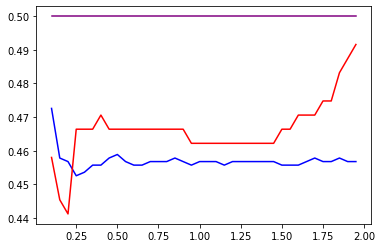

In [ ]:
train_acc=[]
test_acc=[]
ossz=[]

reducer = umap.UMAP(n_components=2)
X_reduced = reducer.fit_transform(X_train)
X_reduced_test = reducer.transform(X_test)
a=0.1
b=2
gran=0.05
for c in np.arange(a,b,gran):
  svm = SVC()

  # Define the grid of hyperparameters to search
  param_grid = {'C': [c],
                'gamma': ["scale"],
                'kernel': ["rbf"]}

  # Perform grid search to tune the hyperparameters of the SVM
  grid_search = GridSearchCV(svm, param_grid, cv=5)
  grid_search.fit(X_reduced, y_train)

  # The best hyperparameters found by grid search
  print("Best hyperparameters:", grid_search.best_params_)

  # The best score achieved by the grid search
  print("Best score:", grid_search.best_score_)

  # The best estimator found by the grid search
  best_svm = grid_search.best_estimator_

  # Predict the class labels for the reduced dataset
  y_pred_train = best_svm.predict(X_reduced)
  y_pred_test = best_svm.predict(X_reduced_test)

  # Print the classification accuracy
  train_acc.append(1-np.mean(y_pred_train == y_train))
  test_acc.append(1-np.mean(y_pred_test == y_test))
  ossz.append(train_acc[-1]+test_acc[-1])
plt.plot(np.arange(a,b,gran),train_acc,color="blue")
plt.plot(np.arange(a,b,gran),test_acc,color="red")
#plt.plot(np.arange(a,b,gran),ossz,"g-")
plt.plot(np.arange(a,b,gran),0.5*np.ones(len(np.arange(a,b,gran))),color="purple")

# svm

In [ ]:
from sklearn.metrics import accuracy_score

Output()

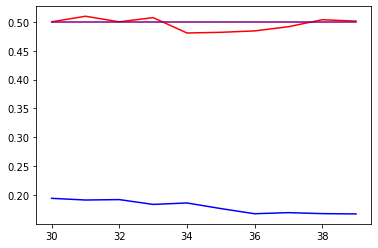

In [ ]:
train_acc=[]  
test_acc=[]

for num_lags in track(np.arange(30,40,1),description="proc"):
  raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv", parse_dates = ["time"], index_col = "time").dropna()
  raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
  raw["returns2"]=(raw["returns"]>=0).astype(int)
  raw.drop(["Open","Spread","Close","High","returns","Volume","Low"],axis=1,inplace=True)
  cols = []
  for lag in range(1, num_lags):
      col_r = "r_lag{}".format(lag)
      raw[col_r] = raw.returns2.shift(lag)
  raw.dropna(inplace = True)

  to=int(len(raw)*0.8)
  X_train=raw.drop(["returns2"],axis=1).iloc[:to].to_numpy()
  y_train=raw["returns2"].iloc[:to].to_numpy().astype(int)
  X_test=raw.drop(["returns2"],axis=1).iloc[to:].to_numpy()
  y_test=raw["returns2"].iloc[to:].to_numpy().astype(int)

  clf = svm.SVC(kernel="rbf")
  clf.fit(X_train,y_train)
  pred_test=clf.predict(X_test)
  pred_train=clf.predict(X_train)

  train_acc.append(1-accuracy_score(y_train,pred_train))
  test_acc.append(1-accuracy_score(y_test,pred_test))
plt.plot(np.arange(30,40,1),train_acc,color="blue")
plt.plot(np.arange(30,40,1),test_acc,color="red")
plt.plot(np.arange(30,40,1),0.5*np.ones(10),color="purple")

In [ ]:
from sklearn import svm

In [ ]:
raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv", parse_dates = ["time"], index_col = "time").dropna()
raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
raw["returns2"]=(raw["returns"]>=0).astype(int)
raw.drop(["Open","Spread","Close","High","returns","Volume","Low"],axis=1,inplace=True)
cols = []
for lag in range(1, 34):
    col_r = "r_lag{}".format(lag)
    raw[col_r] = raw.returns2.shift(lag)
raw.dropna(inplace = True)
to=int(len(raw)*0.8)
X_train=raw.drop(["returns2"],axis=1).iloc[:to].to_numpy()
y_train=raw["returns2"].iloc[:to].to_numpy().astype(int)
X_test=raw.drop(["returns2"],axis=1).iloc[to:].to_numpy()
y_test=raw["returns2"].iloc[to:].to_numpy().astype(int)


clf = svm.SVC(kernel="rbf")
clf.fit(X_train,y_train)
pred_sign=clf.predict(X_test)
pred_train=clf.predict(X_train)
print(confusion_matrix(y_train,pred_train))
print(classification_report(y_train,pred_train))
print(confusion_matrix(y_test,pred_sign))
print(classification_report(y_test,pred_sign))

[[469 266]
 [ 42 875]]
              precision    recall  f1-score   support

           0       0.92      0.64      0.75       735
           1       0.77      0.95      0.85       917

    accuracy                           0.81      1652
   macro avg       0.84      0.80      0.80      1652
weighted avg       0.83      0.81      0.81      1652

[[ 74 141]
 [ 58 141]]
              precision    recall  f1-score   support

           0       0.56      0.34      0.43       215
           1       0.50      0.71      0.59       199

    accuracy                           0.52       414
   macro avg       0.53      0.53      0.51       414
weighted avg       0.53      0.52      0.50       414



# random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Output()

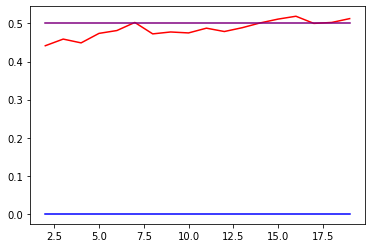

In [ ]:
train_acc=[]  
test_acc=[]

for num_lags in track(np.arange(2,20,1),description="proc"):
  raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv",parse_dates = ["Date"], index_col = "Date").dropna()
  raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
  raw["Volume"]=raw["Volume USDT"]
  raw["returns2"]=(raw["returns"]>=0).astype(int)
  raw.drop(["Open","Unix","Symbol","Volume USDT","Volume BTC","tradecount","returns"],axis=1,inplace=True)
  cols = []
  for lag in range(1, num_lags):
      col_r = "r_lag{}".format(lag)
      raw[col_r] = raw.returns2.shift(lag)
  raw.dropna(inplace = True)

  to=int(len(raw)*0.8)
  X_train=raw.drop(["returns2"],axis=1).iloc[:to].to_numpy()
  y_train=raw["returns2"].iloc[:to].to_numpy().astype(int)
  X_test=raw.drop(["returns2"],axis=1).iloc[to:].to_numpy()
  y_test=raw["returns2"].iloc[to:].to_numpy().astype(int)

  clf = RandomForestClassifier()
  clf.fit(X_train,y_train)
  pred_test=clf.predict(X_test)
  pred_train=clf.predict(X_train)

  train_acc.append(1-accuracy_score(y_train,pred_train))
  test_acc.append(1-accuracy_score(y_test,pred_test))
plt.plot(np.arange(2,20,1),train_acc,color="blue")
plt.plot(np.arange(2,20,1),test_acc,color="red")
plt.plot(np.arange(2,20,1),0.5*np.ones(18),color="purple")

# logstic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

Output()

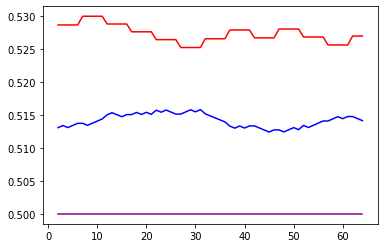

In [ ]:
train_acc=[]  
test_acc=[]
a=2
b=65
for num_lags in track(np.arange(a,b,1),description="proc"):
  raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv",parse_dates = ["Date"], index_col = "Date").dropna()
  raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
  raw["Volume"]=raw["Volume USDT"]
  raw["returns2"]=(raw["returns"]>=0).astype(int)
  raw.drop(["Open","Unix","Symbol","Volume USDT","Volume BTC","tradecount","returns"],axis=1,inplace=True)
  cols = []
  for lag in range(1, num_lags):
      col_r = "r_lag{}".format(lag)
      raw[col_r] = raw.returns2.shift(lag)
  raw.dropna(inplace = True)

  to=int(len(raw)*0.8)
  X_train=raw.drop(["returns2"],axis=1).iloc[:to].to_numpy()
  y_train=raw["returns2"].iloc[:to].to_numpy().astype(int)
  X_test=raw.drop(["returns2"],axis=1).iloc[to:].to_numpy()
  y_test=raw["returns2"].iloc[to:].to_numpy().astype(int)

  clf = LogisticRegression()
  clf.fit(X_train,y_train)
  pred_test=clf.predict(X_test)
  pred_train=clf.predict(X_train)

  train_acc.append(1-accuracy_score(y_train,pred_train))
  test_acc.append(1-accuracy_score(y_test,pred_test))
plt.plot(np.arange(a,b,1),train_acc,color="blue")
plt.plot(np.arange(a,b,1),test_acc,color="red")
plt.plot(np.arange(a,b,1),0.5*np.ones(b-a),color="purple")

In [ ]:
raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv", parse_dates = ["time"], index_col = "time").dropna()
raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
raw["returns2"]=(raw["returns"]>=0).astype(int)
raw.drop(["Open","Spread","Close","High","returns","Volume","Low"],axis=1,inplace=True)
cols = []
for lag in range(1, 40):
    col_r = "r_lag{}".format(lag)
    raw[col_r] = raw.returns2.shift(lag)
raw.dropna(inplace = True)
to=int(len(raw)*0.8)
X_train=raw.drop(["returns2"],axis=1).iloc[:to].to_numpy()
y_train=raw["returns2"].iloc[:to].to_numpy().astype(int)
X_test=raw.drop(["returns2"],axis=1).iloc[to:].to_numpy()
y_test=raw["returns2"].iloc[to:].to_numpy().astype(int)
clf = LogisticRegression()
clf.fit(X_train,y_train)
pred_test=clf.predict(X_test)
pred_train=clf.predict(X_train)

print(confusion_matrix(y_train,pred_train))
print(classification_report(y_train,pred_train))
print(confusion_matrix(y_test,pred_test))
print(classification_report(y_test,pred_test))

[[252 480]
 [172 744]]
              precision    recall  f1-score   support

           0       0.59      0.34      0.44       732
           1       0.61      0.81      0.70       916

    accuracy                           0.60      1648
   macro avg       0.60      0.58      0.57      1648
weighted avg       0.60      0.60      0.58      1648

[[ 83 132]
 [ 63 134]]
              precision    recall  f1-score   support

           0       0.57      0.39      0.46       215
           1       0.50      0.68      0.58       197

    accuracy                           0.53       412
   macro avg       0.54      0.53      0.52       412
weighted avg       0.54      0.53      0.52       412



# GRU2

In [ ]:
raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv",parse_dates = ["Date"], index_col = "Date").dropna()
raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
raw["Volume"]=raw["Volume USDT"]
raw.drop(["Open","Unix","Symbol","Volume USDT","Volume BTC","tradecount"],axis=1,inplace=True)
cols = []
for lag in range(1, 31):
    col_h = "h_lag{}".format(lag)
    col_l = "l_lag{}".format(lag)
    col_r = "c_lag{}".format(lag)
    col_v = "v_lag{}".format(lag)
    raw[col_h] = raw.High.shift(lag)
    cols.append(col_h)
    raw[col_l] = raw.Low.shift(lag)
    cols.append(col_l)
    raw[col_r] = raw.Close.shift(lag)
    cols.append(col_r)
    raw[col_v] = raw.Volume.shift(lag)
    cols.append(col_v)
    raw.dropna(inplace = True)
raw.drop(["High","Low","Volume","Close"],axis=1,inplace=True)

raw["returns2"]=(raw["returns"]>=0).astype(int)

to=int(len(raw)*0.8)
X_train=raw.drop(["returns2","returns"],axis=1).iloc[:to].to_numpy()
y_train=raw["returns2"].iloc[:to].to_numpy().astype(int)
X_test=raw.drop(["returns2","returns"],axis=1).iloc[to:].to_numpy()
y_test=raw["returns2"].iloc[to:].to_numpy().astype(int)

scaler1 = MinMaxScaler()
X_train=scaler1.fit_transform(X_train)
X_test=scaler1.transform(X_test)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

from tensorflow.keras.utils import to_categorical
y_train2 = to_categorical(y_train, 2)
y_test2 = to_categorical(y_test, 2)

X_train=X_train.reshape(len(X_train),30,4)
X_test=X_test.reshape(len(X_test),30,4)


def build_model(hp):
    model = Sequential()
    #model.add(GRU(hp.Int('units1', min_value=5, max_value=200, step=1),activation="tanh",input_shape=(30,4),return_sequences=True))
    model.add(LSTM(hp.Int('units2', min_value=128, max_value=128, step=1),activation="tanh",return_sequences=True))
    model.add(LSTM(hp.Int('units21', min_value=256, max_value=256, step=1),activation="tanh",return_sequences=False))
    model.add(Dense(2,activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#tuner = keras_tuner.RandomSearch(
#      build_model,
#      objective='val_loss',
#      max_trials=1,overwrite = True)
#tuner.search(X_train,y_train2 , epochs=1,batch_size=32, validation_split=0.2)


def build_model_best():
    model = Sequential()
    model.add(GRU(128,activation="tanh",input_shape=(30,4),return_sequences=True))
    model.add(GRU(128,activation="tanh",input_shape=(30,4),return_sequences=True))
    model.add(LSTM(128,activation="tanh",return_sequences=True))
    model.add(LSTM(256,activation="tanh",return_sequences=False))
    model.add(Dense(2,activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


best_model = build_model_best()

early_stopping=EarlyStopping(patience=200, verbose=0)
#checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)
best_model.fit(X_train,y_train2, batch_size=64,epochs=1000, verbose=1, \
                validation_split=0.2,callbacks=[ early_stopping], shuffle=True)

predictions =best_model.predict(X_test)
pred_sign=np.argmax(predictions,axis=1)
pred_train=np.argmax(best_model.predict(X_train),axis=1)
true_sign=np.argmax(y_test2,axis=1)
print(confusion_matrix(np.argmax(y_train2,axis=1),pred_train))
print(confusion_matrix(true_sign,pred_sign))
print(classification_report(true_sign,pred_sign))

(1232, 120) (1232,) (309, 120) (309,)
Epoch 1/1000
16/16 [==============================] - 69s 4s/step - loss: 0.7101 - accuracy: 0.5036 - val_loss: 0.6934 - val_accuracy: 0.5061
Epoch 2/1000
16/16 [==============================] - 63s 4s/step - loss: 0.6927 - accuracy: 0.5360 - val_loss: 0.6934 - val_accuracy: 0.5061
Epoch 3/1000
16/16 [==============================] - 64s 4s/step - loss: 0.6915 - accuracy: 0.5360 - val_loss: 0.6936 - val_accuracy: 0.5061
Epoch 4/1000
16/16 [==============================] - 60s 4s/step - loss: 0.6909 - accuracy: 0.5360 - val_loss: 0.6937 - val_accuracy: 0.5061
Epoch 5/1000
16/16 [==============================] - 63s 4s/step - loss: 0.6910 - accuracy: 0.5360 - val_loss: 0.6941 - val_accuracy: 0.5061
Epoch 6/1000
16/16 [==============================] - 61s 4s/step - loss: 0.6908 - accuracy: 0.5360 - val_loss: 0.6950 - val_accuracy: 0.5061
Epoch 7/1000
16/16 [==============================] - 64s 4s/step - loss: 0.6913 - accuracy: 0.5360 - val_loss

Trial 10 Complete [00h 00m 12s]
val_loss: 0.6848078966140747

Best val_loss So Far: 0.6833024621009827
Total elapsed time: 00h 02m 12s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 59, 47)            94        
                                                                 
 dense_1 (Dense)             (None, 59, 170)           8160      
                                                                 
 dense_2 (Dense)             (None, 59, 33)            5643      
                                                                 
 dense_3 (Dense)             (None, 59, 103)           3502      
                                                                 
 dense_4 (Dense)             (None, 59, 9)             936       
                                                                 
 gru (GRU)                   (None, 59, 9)           

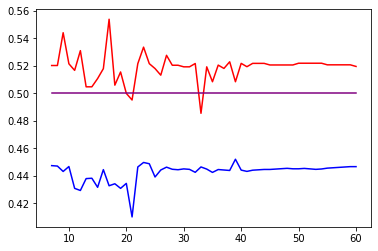

In [ ]:
train_acc=[]  
test_acc=[]
a=7
b=61
num_lag=a
while num_lag<b:
  raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv", parse_dates = ["time"], index_col = "time").dropna()
  raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
  raw["returns2"]=(raw["returns"]>=0).astype(int)
  raw.drop(["Open","Spread","Close","High","returns","Volume","Low"],axis=1,inplace=True)
  cols = []
  for lag in range(1, num_lag):
      col_r = "r_lag{}".format(lag)
      raw[col_r] = raw.returns2.shift(lag)
  raw.dropna(inplace = True)
  to=int(len(raw)*0.8)
  X_train=raw.drop(["returns2"],axis=1).iloc[:to].to_numpy()
  y_train=raw["returns2"].iloc[:to].to_numpy().astype(int)
  X_test=raw.drop(["returns2"],axis=1).iloc[to:].to_numpy()
  y_test=raw["returns2"].iloc[to:].to_numpy().astype(int)

  from tensorflow.keras.utils import to_categorical
  y_train2 = to_categorical(y_train, 2)
  y_test2 = to_categorical(y_test, 2)


  def build_model(hp):
      model = Sequential()
      model.add(Dense(hp.Int('units1', min_value=5, max_value=200, step=1),activation="relu",input_shape=(num_lag-1,1)))
      model.add(Dense(hp.Int('units2', min_value=5, max_value=180, step=1),activation="relu"))
      model.add(Dense(hp.Int('units3', min_value=5, max_value=160, step=1),activation="relu"))
      model.add(Dense(hp.Int('units4', min_value=5, max_value=140, step=1),activation="relu"))
      model.add(Dense(hp.Int('units5', min_value=5, max_value=120, step=1),activation="relu"))
      model.add(GRU(hp.Int('units5', min_value=5, max_value=120, step=1),activation="tanh",return_sequences=True))
      model.add(LSTM(hp.Int('units5', min_value=5, max_value=120, step=1),activation="tanh"))
      model.add(Dense(2,activation="softmax"))

      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      return model

  tuner = keras_tuner.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,overwrite = True)
  tuner.search(X_train,y_train2 , epochs=5, validation_split=0.2)
  best_model = tuner.get_best_models()[0]
  best_model.summary()

  early_stopping=EarlyStopping(patience=10, verbose=0)
  checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)
  best_model.fit(X_train,y_train2, batch_size=50,epochs=100, verbose=0, \
                  validation_split=0.2,callbacks=[checkpointer, early_stopping], shuffle=True)

  predictions =best_model.predict(X_test)
  predistions2=best_model.predict(X_train)
  pred_test=np.argmax(predictions,axis=1)
  pred_train=np.argmax(predistions2,axis=1)
  train_acc.append(1-accuracy_score(y_train,pred_train))
  test_acc.append(1-accuracy_score(y_test,pred_test))
  num_lag+=1

plt.plot(np.arange(a,b,1),train_acc,color="blue")
plt.plot(np.arange(a,b,1),test_acc,color="red")
plt.plot(np.arange(a,b,1),0.5*np.ones(b-a),color="purple")

In [ ]:
pred_sign=-(predictions>=0).astype(int)+(predictions<0).astype(int)
true_sign=(y_true>=0).astype(int)-(y_true<0).astype(int)
print(confusion_matrix(true_sign,pred_sign))
print(classification_report(true_sign,pred_sign))

[[215  75]
 [216  92]]
              precision    recall  f1-score   support

          -1       0.50      0.74      0.60       290
           1       0.55      0.30      0.39       308

    accuracy                           0.51       598
   macro avg       0.52      0.52      0.49       598
weighted avg       0.53      0.51      0.49       598



In [ ]:
X_test.shape

(598, 56)

# GRU

In [ ]:
def build_model(hp):
    model = Sequential()

    model.add(LSTM(hp.Int('units2', min_value=1, max_value=200, step=1), return_sequences=True, input_shape=(60,1)))
    model.add(GRU(hp.Int('units2', min_value=1, max_value=200, step=1), return_sequences=True))
    model.add(LSTM(hp.Int('units2', min_value=1, max_value=200, step=1), return_sequences=False))
    model.add(Dense(hp.Int('units3', min_value=5, max_value=100, step=1)))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [ ]:
tuner = keras_tuner.RandomSearch(
      build_model,
      objective='val_loss',
      max_trials=10,overwrite = True)
tuner.search(X_train,y_train , epochs=10, validation_split=0.2)
best_model = tuner.get_best_models()[0]
best_model.summary()

Trial 10 Complete [00h 00m 11s]
val_loss: 0.8127514123916626

Best val_loss So Far: 0.8071630597114563
Total elapsed time: 00h 02m 12s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 109)           48396     
                                                                 
 gru (GRU)                   (None, 60, 109)           71940     
                                                                 
 lstm_1 (LSTM)               (None, 109)               95484     
                                                                 
 dense (Dense)               (None, 29)                3190      
                                                                 
 dense_1 (Dense)             (None, 1)                 30        
                                                                 
Total params: 219,040
Trainable params: 219,040
Non-t

In [ ]:
#best_model=build_best()
early_stopping=EarlyStopping(patience=100, verbose=0)
checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)
best_model.fit(X_train,y_train, batch_size=32,epochs=1000, verbose=0, \
                validation_split=0.1,callbacks=[checkpointer, early_stopping], shuffle=True)


Epoch 1: val_loss improved from inf to 1.13291, saving model to weights1.hdf5

Epoch 2: val_loss did not improve from 1.13291

Epoch 3: val_loss did not improve from 1.13291

Epoch 4: val_loss improved from 1.13291 to 1.13181, saving model to weights1.hdf5

Epoch 5: val_loss did not improve from 1.13181

Epoch 6: val_loss did not improve from 1.13181

Epoch 7: val_loss did not improve from 1.13181

Epoch 8: val_loss did not improve from 1.13181

Epoch 9: val_loss did not improve from 1.13181

Epoch 10: val_loss did not improve from 1.13181

Epoch 11: val_loss did not improve from 1.13181

Epoch 12: val_loss did not improve from 1.13181

Epoch 13: val_loss did not improve from 1.13181

Epoch 14: val_loss did not improve from 1.13181

Epoch 15: val_loss did not improve from 1.13181

Epoch 16: val_loss did not improve from 1.13181

Epoch 17: val_loss did not improve from 1.13181

Epoch 18: val_loss did not improve from 1.13181

Epoch 19: val_loss did not improve from 1.13181

Epoch 20: v

In [ ]:
predictions = scaler2.inverse_transform(best_model.predict(X_test)).flatten()
y_true=scaler2.inverse_transform(y_test.reshape(-1,1)).flatten()
pred_sign=(predictions>=0).astype(int)-(predictions<0).astype(int)
true_sign=(y_true>=0).astype(int)-(y_true<0).astype(int)
print(confusion_matrix(true_sign,pred_sign))
print(classification_report(true_sign,pred_sign))

2/2 [==============================] - 1s 9ms/step
[[11 12]
 [21 10]]
              precision    recall  f1-score   support

          -1       0.34      0.48      0.40        23
           1       0.45      0.32      0.38        31

    accuracy                           0.39        54
   macro avg       0.40      0.40      0.39        54
weighted avg       0.41      0.39      0.39        54

